In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
# Set random seeds
sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_split = np.random.seed(42)
model_seed = np.random.seed(73)

In [3]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""

df = bq.Client().query(query).to_dataframe()
df = df.sample(frac=0.1)
df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
1261133,272179791,8.10,55.867402,30.627942,11.085899,NaN,None,NL,None,1969.0,5,0.865100,11.202841,556.0,South Holland
179634,270914429,7.01,106.684473,46.583981,18.451951,NaN,None,NL,None,1920.0,8,0.785993,14.494769,692.0,South Holland
1000509,271604097,7.92,71.714472,42.267066,16.199849,NaN,None,NL,None,1956.0,7,0.710242,14.524474,535.0,South Holland
1147293,279653820,7.77,44.937904,26.973740,9.604454,NaN,None,NL,None,1964.0,5,0.880988,10.418087,620.0,South Holland
1217167,264135079,2.34,8.834287,12.025071,4.303666,NaN,None,NL,None,1968.0,5,0.876200,6.975009,662.0,South Holland


In [4]:
df.set_index('osm_way_id', inplace=True)

In [5]:
df.shape

(163867, 14)

In [6]:
df.dtypes

bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object

In [7]:

df["city"] = df["city"].astype("category")
df["state_name"] = df["state_name"].astype("category")
df["country"] = df["country"].astype("category")
df["postcode"] = df["postcode"].astype("category")
# df["year"] = df["year"].astype(float).astype("Int64")
# df["count_vertices"] = df["count_vertices"].astype(float).astype("Int64")
# df["count_neighbor"] = df["count_neighbor"].astype(float).astype("Int64")
# df["building_levels"] = df["building_levels"].astype(float).astype("Int64")
df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
df.isna().sum()

bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161573
city               163765
country                 0
postcode           163771
year                    7
count_vertices          0
compactness             0
complexity              0
count_neighbor         33
state_name              0
dtype: int64

In [9]:
print('count unique city:', len(pd.unique(df['city'])))
print('unique city:', pd.unique(df['city']))

print('\ncount unique postcode:', len(pd.unique(df['postcode'])))
print('unique postcode:', pd.unique(df['postcode']))

print('\ncount unique year:', len(pd.unique(df['year'])))
print('unique year:', pd.unique(df['year']))

count unique city: 43
unique city: [NaN, 's-Gravendeel, 's-Gravenhage, Voorburg, Spijkenisse, ..., Westmaas, 's-Gravenzande, Vlaardingen, Puttershoek, Leiden]
Length: 43
Categories (42, object): ['s-Gravendeel, 's-Gravenhage, Voorburg, Spijkenisse, ..., 's-Gravenzande, Vlaardingen, Puttershoek, Leiden]

count unique postcode: 90
unique postcode: [NaN, 3295KG, 2493WZ, 2517JS, 2544EK, ..., 3297AB, 2316CZ, 2912RB, 3076BB, 2521EN]
Length: 90
Categories (89, object): [3295KG, 2493WZ, 2517JS, 2544EK, ..., 2316CZ, 2912RB, 3076BB, 2521EN]

count unique year: 385
unique year: [1969.         1920.         1956.         1964.         1968.
 1935.         2003.         1983.         1994.         1980.
 1986.         2009.         2001.         2017.         1996.
 1970.         1998.         2015.         1976.         2002.
 1992.         1930.         1974.         1973.         1987.
 1904.         1963.         2005.         2006.         1926.
 2016.         1906.         1919.         1953.

In [10]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# cat_cols = ["city", "postcode"]
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]


In [11]:
cat_df = df[cat_cols]
cat_df

,city,country,postcode,state_name
osm_way_id,,,,
272179791,NaN,NL,NaN,South Holland
270914429,NaN,NL,NaN,South Holland
271604097,NaN,NL,NaN,South Holland
279653820,NaN,NL,NaN,South Holland
264135079,NaN,NL,NaN,South Holland
...,...,...,...,...
269646293,NaN,NL,NaN,South Holland
285553360,NaN,NL,NaN,South Holland
427606715,NaN,NL,NaN,South Holland


In [12]:
num_df = df[num_cols]
num_df.describe()


,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2294.000000,163860.000000,163867.000000,163867.000000,163867.000000,163834.000000
mean,130.765575,34.547900,12.537839,1.527027,1970.070212,7.309739,0.820272,11.516670,626.205220
std,1182.297173,44.164229,15.424906,1.764087,36.822677,5.038604,0.070138,5.193384,307.696479
min,0.104378,2.253801,0.845110,-3.000000,1230.000000,4.000000,0.103714,3.103151,1.000000
25%,11.218958,13.927939,5.090746,1.000000,1957.000000,5.000000,0.791563,7.598820,429.000000
50%,50.177249,29.795345,10.867664,1.000000,1976.000000,5.000000,0.843833,11.141753,638.000000
75%,71.670580,38.925523,14.331393,1.000000,1993.000000,8.000000,0.871962,13.339646,832.000000
max,105192.634351,3386.650409,841.186456,39.000000,2020.000000,270.000000,0.999655,234.086835,2129.000000


In [13]:
num_df.isna().sum()

area                    0
perimeter               0
length                  0
building_levels    161573
year                    7
count_vertices          0
compactness             0
complexity              0
count_neighbor         33
dtype: int64

In [14]:
num_df = df[num_cols].fillna(df[num_cols].mean())
num_df.isna().sum()

area               0
perimeter          0
length             0
building_levels    0
year               0
count_vertices     0
compactness        0
complexity         0
count_neighbor     0
dtype: int64

In [28]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000,163867.000000
mean,130.765575,34.547900,12.537839,1.527027,1970.070212,7.309739,0.820272,11.516670,626.205220
std,1182.297173,44.164229,15.424906,0.208678,36.821891,5.038604,0.070138,5.193384,307.665495
min,0.104378,2.253801,0.845110,-3.000000,1230.000000,4.000000,0.103714,3.103151,1.000000
25%,11.218958,13.927939,5.090746,1.527027,1957.000000,5.000000,0.791563,7.598820,429.000000
50%,50.177249,29.795345,10.867664,1.527027,1976.000000,5.000000,0.843833,11.141753,638.000000
75%,71.670580,38.925523,14.331393,1.527027,1993.000000,8.000000,0.871962,13.339646,832.000000
max,105192.634351,3386.650409,841.186456,39.000000,2020.000000,270.000000,0.999655,234.086835,2129.000000


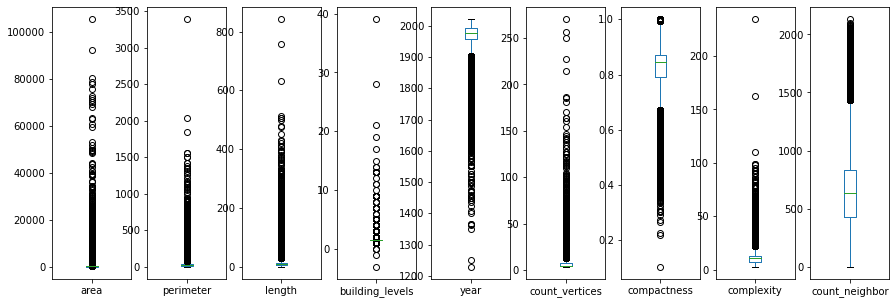

In [77]:
num_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()
plt.savefig('feature_engineering/num_df.png', dpi=600)

In [31]:
num_df

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
osm_way_id,,,,,,,,,
272179791,55.867402,30.627942,11.085899,1.527027,1969.0,5,0.865100,11.202841,556.0
270914429,106.684473,46.583981,18.451951,1.527027,1920.0,8,0.785993,14.494769,692.0
271604097,71.714472,42.267066,16.199849,1.527027,1956.0,7,0.710242,14.524474,535.0
279653820,44.937904,26.973740,9.604454,1.527027,1964.0,5,0.880988,10.418087,620.0
264135079,8.834287,12.025071,4.303666,1.527027,1968.0,5,0.876200,6.975009,662.0
...,...,...,...,...,...,...,...,...,...
269646293,403.303557,114.049462,38.311298,1.527027,1926.0,26,0.624206,25.449850,728.0
285553360,17.360519,17.642582,6.567306,1.527027,1970.0,7,0.837190,8.643139,539.0
427606715,6.280046,10.068793,3.578123,1.527027,2016.0,5,0.882285,6.360434,815.0


In [33]:
corr_df = df[num_cols+ label_col]
corr_df

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
osm_way_id,,,,,,,,,,
272179791,55.867402,30.627942,11.085899,NaN,1969.0,5,0.865100,11.202841,556.0,8.10
270914429,106.684473,46.583981,18.451951,NaN,1920.0,8,0.785993,14.494769,692.0,7.01
271604097,71.714472,42.267066,16.199849,NaN,1956.0,7,0.710242,14.524474,535.0,7.92
279653820,44.937904,26.973740,9.604454,NaN,1964.0,5,0.880988,10.418087,620.0,7.77
264135079,8.834287,12.025071,4.303666,NaN,1968.0,5,0.876200,6.975009,662.0,2.34
...,...,...,...,...,...,...,...,...,...,...
269646293,403.303557,114.049462,38.311298,NaN,1926.0,26,0.624206,25.449850,728.0,7.39
285553360,17.360519,17.642582,6.567306,NaN,1970.0,7,0.837190,8.643139,539.0,3.26
427606715,6.280046,10.068793,3.578123,NaN,2016.0,5,0.882285,6.360434,815.0,3.65


In [34]:
corr_df = corr_df.fillna(corr_df.mean())
corr_df.isna().sum()

area               0
perimeter          0
length             0
building_levels    0
year               0
count_vertices     0
compactness        0
complexity         0
count_neighbor     0
bldg_height        0
dtype: int64

In [35]:
corr = corr_df.corr()
corr

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor,bldg_height
area,1.000000,0.774402,0.770202,0.013214,0.025409,0.221346,-0.095221,0.496802,-0.115997,0.071537
perimeter,0.774402,1.000000,0.984919,0.052349,-0.015611,0.532567,-0.414636,0.902301,-0.251396,0.339087
length,0.770202,0.984919,1.000000,0.057283,-0.020590,0.488943,-0.421582,0.897482,-0.254783,0.346582
building_levels,0.013214,0.052349,0.057283,1.000000,-0.004792,0.046847,-0.029795,0.067100,-0.030008,0.194235
year,0.025409,-0.015611,-0.020590,-0.004792,1.000000,-0.076841,0.151086,-0.075877,-0.082732,-0.184848
count_vertices,0.221346,0.532567,0.488943,0.046847,-0.076841,1.000000,-0.529934,0.630754,-0.140718,0.347237
compactness,-0.095221,-0.414636,-0.421582,-0.029795,0.151086,-0.529934,1.000000,-0.649427,0.114681,-0.329176
complexity,0.496802,0.902301,0.897482,0.067100,-0.075877,0.630754,-0.649427,1.000000,-0.293838,0.522271
count_neighbor,-0.115997,-0.251396,-0.254783,-0.030008,-0.082732,-0.140718,0.114681,-0.293838,1.000000,-0.032727
bldg_height,0.071537,0.339087,0.346582,0.194235,-0.184848,0.347237,-0.329176,0.522271,-0.032727,1.000000


In [36]:
import seaborn as sns


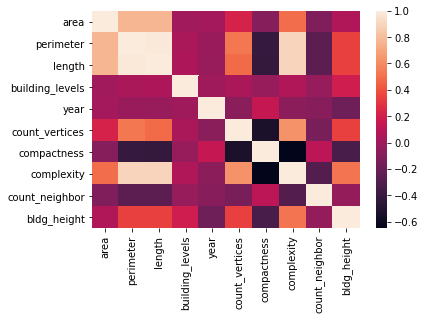

In [76]:
sns.heatmap(corr)
plt.savefig('feature_engineering/corr_heatmap.png', dpi=600)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

length, perimeter and complexity are highly correlated to each other, we should drop a couple of them. Looking at the correlation between those 3 features to bldg_height, complexity is a better indicator of bldg_height. Therefore it is chosen to keep. 

In [81]:
X = df.drop('bldg_height', axis=1).drop(cat_cols, axis=1).drop(['length', 'perimeter'], axis=1)    # drop cat_cols since can't evaluate non-numeric
y = df['bldg_height']
X = X.fillna(X.mean())
X, y

(                  area  building_levels    year  count_vertices  compactness  \
 osm_way_id                                                                     
 272179791    55.867402         1.527027  1969.0               5     0.865100   
 270914429   106.684473         1.527027  1920.0               8     0.785993   
 271604097    71.714472         1.527027  1956.0               7     0.710242   
 279653820    44.937904         1.527027  1964.0               5     0.880988   
 264135079     8.834287         1.527027  1968.0               5     0.876200   
 ...                ...              ...     ...             ...          ...   
 269646293   403.303557         1.527027  1926.0              26     0.624206   
 285553360    17.360519         1.527027  1970.0               7     0.837190   
 427606715     6.280046         1.527027  2016.0               5     0.882285   
 253318868     6.044720         1.527027  1984.0               5     0.868923   
 265836952   200.324355     

In [82]:
X.columns


Index(['area', 'building_levels', 'year', 'count_vertices', 'compactness',
       'complexity', 'count_neighbor'],
      dtype='object')

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=1)

In [84]:
# feature selection function
def select_features(score_function, X_train, y_train, X_test, k):
	# configure to select all features
	fs = SelectKBest(score_func=score_function, k=k, )
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


Feature 0: 717.149939
Feature 1: 5037.902843
Feature 2: 4672.149227
Feature 3: 18466.923345
Feature 4: 15899.321649
Feature 5: 49537.353273
Feature 6: 150.213545


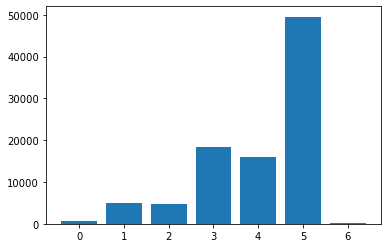

In [85]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(f_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.savefig('feature_engineering/f_regression_scores_except_length_perimeter.png', dpi=600)
plt.show()

In [66]:
X = df.drop('bldg_height', axis=1).drop(cat_cols, axis=1)
y = df['bldg_height']
X = X.fillna(X.mean())
X, y

(                  area   perimeter     length  building_levels    year  \
 osm_way_id                                                               
 272179791    55.867402   30.627942  11.085899         1.527027  1969.0   
 270914429   106.684473   46.583981  18.451951         1.527027  1920.0   
 271604097    71.714472   42.267066  16.199849         1.527027  1956.0   
 279653820    44.937904   26.973740   9.604454         1.527027  1964.0   
 264135079     8.834287   12.025071   4.303666         1.527027  1968.0   
 ...                ...         ...        ...              ...     ...   
 269646293   403.303557  114.049462  38.311298         1.527027  1926.0   
 285553360    17.360519   17.642582   6.567306         1.527027  1970.0   
 427606715     6.280046   10.068793   3.578123         1.527027  2016.0   
 253318868     6.044720   10.030255   3.626005         1.527027  1984.0   
 265836952   200.324355   59.544742  22.177997         1.527027  2001.0   
 
             count_vert

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=1)

In [68]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

In [69]:


reg = RandomForestRegressor(n_jobs=-1)
reg.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(reg.score(X_test, y_test)))

Accuracy on test data: 0.72


In [70]:
result = permutation_importance(reg, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)
perm_sorted_idx = result.importances_mean.argsort()


In [71]:

tree_importance_sorted_idx = np.argsort(reg.feature_importances_)
tree_indices = np.arange(0, len(reg.feature_importances_)) + 0.5


In [74]:
feature_names = X.columns
feature_names

Index(['area', 'perimeter', 'length', 'building_levels', 'year',
       'count_vertices', 'compactness', 'complexity', 'count_neighbor'],
      dtype='object')

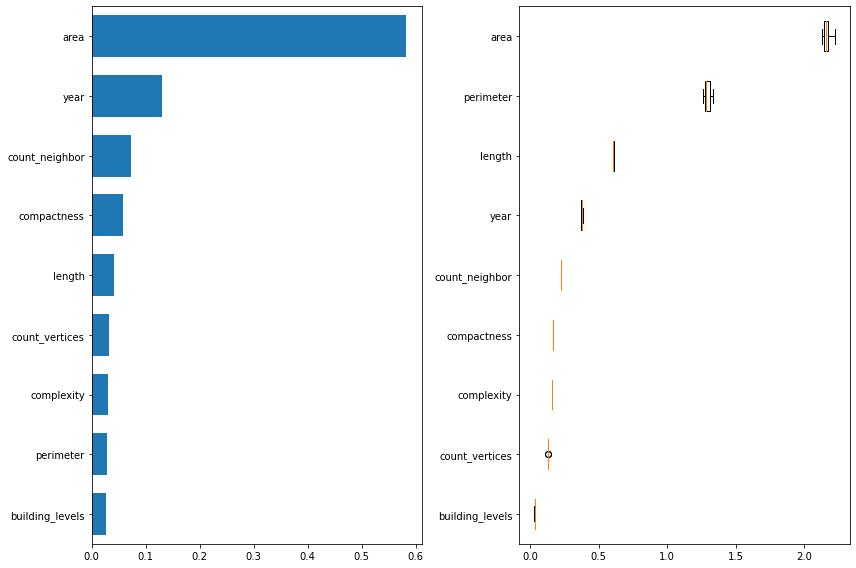

In [75]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         reg.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(reg.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

In [ ]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(mutual_info_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [14]:
df.columns

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'country', 'postcode', 'year', 'count_vertices', 'compactness',
       'complexity', 'count_neighbor', 'state_name'],
      dtype='object')

In [15]:
# drop country and state_name as they are irrelevant 
df = df.drop(['country', 'state_name'], axis=1)
print(df.columns)

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'postcode', 'year', 'count_vertices', 'compactness', 'complexity',
       'count_neighbor'],
      dtype='object')


In [16]:
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
print(cat_cols)
print(num_cols)

['city', 'postcode']
['area', 'perimeter', 'length', 'building_levels', 'year', 'count_vertices', 'compactness', 'complexity', 'count_neighbor']


In [17]:
cat_df = df[cat_cols]

In [18]:
X = df.drop('bldg_height', axis=1)
y = df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [19]:
X, y

(                 area  perimeter     length  building_levels city postcode  \
 osm_way_id                                                                   
 277888450    7.865621  11.414314   4.107010              NaN  NaN      NaN   
 279597957   37.598584  24.965267   8.752577              NaN  NaN      NaN   
 272135179   53.874613  37.381286  13.882549              NaN  NaN      NaN   
 268257032   51.870176  29.729731  10.702916              NaN  NaN      NaN   
 270835938   67.162535  40.157170  16.511125              NaN  NaN      NaN   
 ...               ...        ...        ...              ...  ...      ...   
 268873072   11.911142  14.044602   4.904979              NaN  NaN      NaN   
 289163195   48.823792  28.889704  10.542592              NaN  NaN      NaN   
 274106342   55.111097  32.177520  11.840878              NaN  NaN      NaN   
 280059992   21.833957  16.757716   5.405664              NaN  NaN      NaN   
 272960802   48.395291  29.143001  10.558516        

In [20]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])


In [21]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
print(len(cat_cols))
print(len(num_cols))
print(len(df.columns))

2
9
12


In [23]:
preprocessor = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [24]:
# ('imputer', KNNImputer(n_neighbors=50, weights='uniform'))
# ,('kbest', SelectKBest(f_regression, k=5))
# ,('kbest', SelectKBest(f_regression, k=50))

In [25]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [26]:
# print(sorted(sklearn.metrics.SCORERS.keys()) )

In [47]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))


In [48]:
mae_reg_scores = {}

In [50]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: -1.816336 (std: 0.010333, max: -1.799928, min: -1.831252)
DT: avg: -1.404466 (std: 0.015408, max: -1.379275, min: -1.420870)
KNN: avg: -1.199057 (std: 0.006564, max: -1.189417, min: -1.209794)
RF: avg: -1.047294 (std: 0.007239, max: -1.035608, min: -1.055216)
AB: avg: -3.565269 (std: 1.979672, max: -1.646388, min: -7.236738)
B: avg: -1.106571 (std: 0.006693, max: -1.096321, min: -1.114045)
GB: avg: -1.160853 (std: 0.006087, max: -1.151424, min: -1.170653)


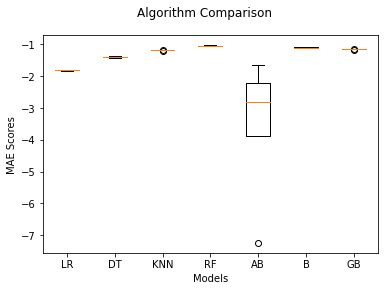

In [52]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MAE Scores')
plt.show()

In [53]:
plt.savefig('South-Holland-Sample_MAE.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [54]:
del mae_reg_scores['AB']
mae_reg_scores

{'LR': array([-1.81998226, -1.81890122, -1.81161801, -1.83125165, -1.79992825]),
 'DT': array([-1.41294192, -1.41490363, -1.37927482, -1.42087037, -1.39434016]),
 'KNN': array([-1.19892346, -1.20040836, -1.19674476, -1.20979389, -1.1894169 ]),
 'RF': array([-1.04745913, -1.05521568, -1.04379044, -1.05439495, -1.03560847]),
 'B': array([-1.10642315, -1.11345517, -1.10261332, -1.11404521, -1.0963206 ]),
 'GB': array([-1.16067112, -1.17065332, -1.16037441, -1.16113929, -1.15142448])}

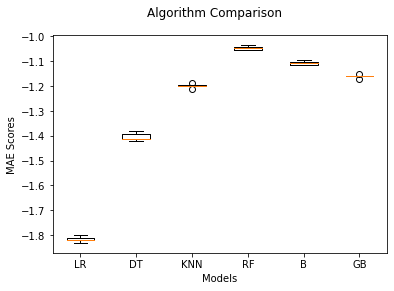

In [55]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MAE Scores')
plt.show()


In [56]:
plt.savefig('South-Holland-Sample_MAE_Except-AB.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [57]:
mse_reg_scores = {}

In [58]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: -7.422129 (std: 0.360516, max: -6.893300, min: -7.788291)
DT: avg: -8.433696 (std: 0.432031, max: -7.922503, min: -9.025510)
KNN: avg: -5.320080 (std: 0.275134, max: -4.845582, min: -5.580188)
RF: avg: -4.405509 (std: 0.277818, max: -3.918235, min: -4.638007)
AB: avg: -26.382746 (std: 16.676621, max: -11.853235, min: -50.933697)
B: avg: -4.819208 (std: 0.263251, max: -4.313381, min: -5.000472)
GB: avg: -4.753524 (std: 0.356573, max: -4.199881, min: -5.092138)


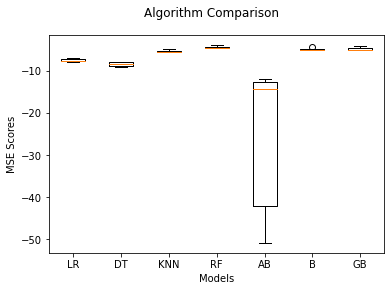

In [59]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MSE Scores')
plt.show()

In [60]:
plt.savefig('South-Holland-Sample_MSE.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [62]:
del mse_reg_scores['AB']
mse_reg_scores

{'LR': array([-7.78829073, -7.64683462, -7.69418554, -7.08803568, -6.8933001 ]),
 'DT': array([-8.76107826, -8.48589714, -7.92250297, -9.02550995, -7.97349309]),
 'KNN': array([-5.48366679, -5.51524265, -5.58018807, -5.17571874, -4.84558155]),
 'RF': array([-4.60446387, -4.59664178, -4.63800662, -4.27019606, -3.91823513]),
 'B': array([-4.98290992, -4.99463979, -5.00047249, -4.80463661, -4.31338108]),
 'GB': array([-5.00971008, -5.09213752, -5.00503159, -4.46085806, -4.19988141])}

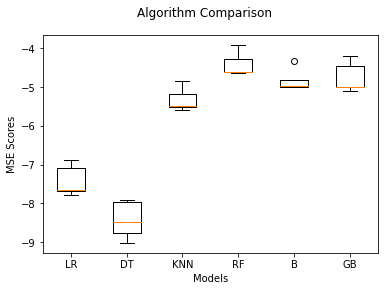

In [63]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MSE Scores')
plt.show()

In [64]:
plt.savefig('South-Holland-Sample_MSE_Except-AB.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [65]:
r2_reg_scores = {}

In [66]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)" % (name, scores.mean(), scores.std(), scores.max(), scores.min())
    print(msg)

LR: avg: 0.492259 (std: 0.009467, max: 0.504397, min: 0.481174)
DT: avg: 0.413305 (std: 0.030832, max: 0.471272, min: 0.382493)
KNN: avg: 0.636084 (std: 0.008596, max: 0.650080, min: 0.623723)
RF: avg: 0.699121 (std: 0.011391, max: 0.720305, min: 0.687125)
AB: avg: -0.396400 (std: 0.640346, max: 0.330139, min: -1.564800)
B: avg: 0.669879 (std: 0.011833, max: 0.689830, min: 0.658716)
GB: avg: 0.674916 (std: 0.014446, max: 0.696017, min: 0.660086)


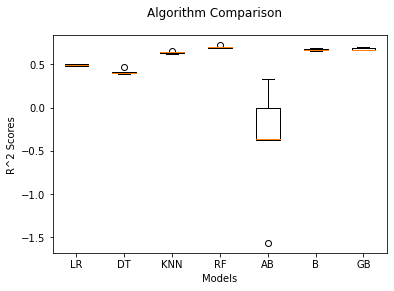

In [67]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.show()

In [68]:
plt.savefig('South-Holland-Sample_R2.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [69]:
del r2_reg_scores['AB']
r2_reg_scores

{'LR': array([0.48371979, 0.48979651, 0.48117372, 0.50439716, 0.50220607]),
 'DT': array([0.4157211 , 0.39808859, 0.4712717 , 0.382493  , 0.39895007]),
 'KNN': array([0.63649166, 0.63201819, 0.62372259, 0.63810835, 0.65008036]),
 'RF': array([0.69506387, 0.6929133 , 0.68712507, 0.70019655, 0.72030501]),
 'B': array([0.6587159 , 0.66310914, 0.66082098, 0.67691931, 0.68983042]),
 'GB': array([0.66788884, 0.66008608, 0.66247664, 0.6881096 , 0.69601735])}

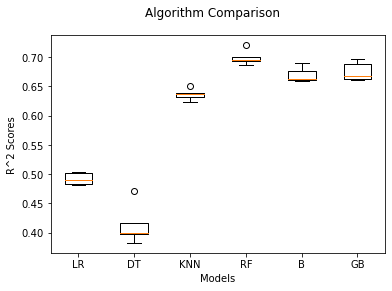

In [72]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.show()

In [73]:
plt.savefig('South-Holland-Sample_R2_Except-AB.png', dpi=300)

<Figure size 432x288 with 0 Axes>

In [78]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_jobs=-1))])

In [ ]:
grid_params = {
    'preprocessor__num_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
best_params

In [ ]:
best_estimator = grid_search.best_estimator_
print(best_estimator)


In [ ]:
best_score = grid_search.best_score_
best_score

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', BaggingRegressor())])

In [ ]:
grid_params = {
    'preprocessor__year_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__bldg_lvls_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    'regressor__learning_rate': [0.05, 0.01, 0.1, 0.5],
    'regressor__criterion': ['friedman_mse', 'mse'],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)